<a href="https://colab.research.google.com/github/linainsaf/advanced_machine_learning/blob/main/RNN_sentiment_analysis_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://upload.wikimedia.org/wikipedia/fr/8/81/Sciences_SU.png" width="240" height="240" align="center"/>


# MLA 703. RNN-LSTM et architectures avancées [Analyse de sentiment]

In [ ]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# Importation des modules

In [228]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


# Fonction utile 

In [229]:
def plot_history(history):
  # On trace la loss et l'accuracy du modèle
  # On trace l'évolution de l'accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy']) 
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # On trace l'évolution de la loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [230]:
def predict(model):

  # On prédit sur l'ensemble de test

  # On prédit sur les données de test
  y_hat = model.predict(x_test)

  # On tranforme les prédictions en labels
  i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
  i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

  y_pred   = np.zeros(len(y_hat))
  y_pred[i_pos] = 1
  y_pred[i_neg] = 0
  return y_pred

## 1. Charger les données

In [231]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)
                                            

## 2. Formater/Préparer les données

In [232]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print(len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

# Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)

In [245]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import  Adam
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_rnn_simple = Sequential()
model_rnn_simple.add(Embedding(num_words, embed_size))                 # layer embedding
model_rnn_simple.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model_rnn_simple.add(Dropout(0.25))                                    # layer Dropout
model_rnn_simple.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_rnn_simple.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_rnn_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_61 (Embedding)     (None, None, 128)         640000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 65        
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [ ]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_rnn_simple = model_rnn_simple.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 3s 59ms/step - loss: 2.2465 - accuracy: 0.5095 - val_loss: 0.8804 - val_accuracy: 0.5712
Epoch 2/10
35/35 [==============================] - 2s 51ms/step - loss: 1.0578 - accuracy: 0.6231 - val_loss: 0.7969 - val_accuracy: 0.5820
Epoch 3/10
35/35 [==============================] - 2s 51ms/step - loss: 0.4841 - accuracy: 0.7800 - val_loss: 0.7368 - val_accuracy: 0.5748
Epoch 4/10
35/35 [==============================] - 2s 51ms/step - loss: 0.2115 - accuracy: 0.9261 - val_loss: 1.1926 - val_accuracy: 0.5333
Epoch 5/10
35/35 [==============================] - 2s 55ms/step - loss: 0.0698 - accuracy: 0.9892 - val_loss: 1.6880 - val_accuracy: 0.5441
Epoch 6/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0200 - accuracy: 0.9986 - val_loss: 2.0130 - val_accuracy: 0.5514
Epoch 7/10
35/35 [==============================] - 2s 50ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 2.1822 - val_accuracy: 0.5640
Epoch 8/10
35

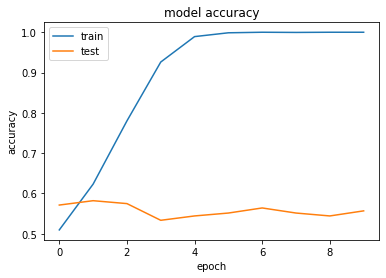

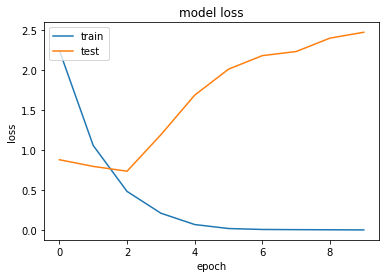

In [ ]:
plot_history(history_rnn_simple)

In [ ]:
y_pred=predict(model_rnn_simple)

In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 236 1123]
 [ 177 1427]] 

L accuracy sur le jeu de test est :
 0.5612554843064461


Comments : 
- l'accuracy n'est pas tres tres bonne, on remarque sur la matrice de confusion que nos données test ne sont pas tres bien predit ( 143 + 1025 ) sur l'ensemble de test qui sont mal classé . 
- notre model overfitt rapidement, ce qui fait qu'on ne peux pas l'entrainer plus. 

Tous les RNN ont des boucles de rétroaction dans la couche récurrente. Cela leur permet de conserver des informations en « mémoire » au fil du temps. Mais, il peut être difficile de former des RNN standard pour résoudre des problèmes qui nécessitent l'apprentissage de dépendances temporelles à long terme. C'est parce que le gradient de la fonction de perte décroît de façon exponentielle avec le temps  (problème de fuite de gradient)

# RNN-LSTM gauche-droite classique 

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, embed_size))                 # layer embedding
model_lstm.add(LSTM(RNN_size,return_sequences = False))          # layer lstm
#model_lstm.add(Dropout(0.25))                                    # layer Dropout
model_lstm.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_lstm.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 128)         640000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# On entraine le réseau
batch_size = 32                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_lstm = model_lstm.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
70/70 [==============================] - 9s 94ms/step - loss: 0.8225 - accuracy: 0.5956 - val_loss: 0.6222 - val_accuracy: 0.6667
Epoch 2/10
70/70 [==============================] - 6s 85ms/step - loss: 0.4440 - accuracy: 0.8638 - val_loss: 0.9307 - val_accuracy: 0.8234
Epoch 3/10
70/70 [==============================] - 6s 87ms/step - loss: 0.3081 - accuracy: 0.9360 - val_loss: 0.6719 - val_accuracy: 0.8288
Epoch 4/10
70/70 [==============================] - 6s 85ms/step - loss: 0.2751 - accuracy: 0.9626 - val_loss: 1.1675 - val_accuracy: 0.8072
Epoch 5/10
70/70 [==============================] - 6s 86ms/step - loss: 0.1459 - accuracy: 0.9869 - val_loss: 1.2890 - val_accuracy: 0.8270
Epoch 6/10
70/70 [==============================] - 6s 86ms/step - loss: 0.1321 - accuracy: 0.9914 - val_loss: 1.4543 - val_accuracy: 0.8288
Epoch 7/10
70/70 [==============================] - 6s 86ms/step - loss: 0.1312 - accuracy: 0.9914 - val_loss: 1.5897 - val_accuracy: 0.8324
Epoch 8/10
70

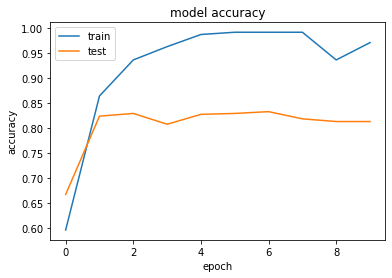

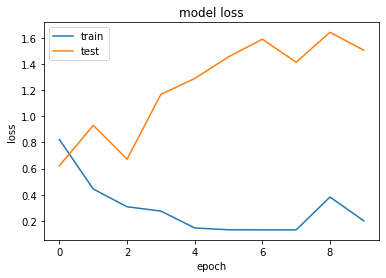

In [ ]:
plot_history(history_lstm)

In [ ]:
y_pred=predict(model_lstm)

In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[ 794  565]
 [ 119 1485]] 

L accuracy sur le jeu de test est :
 0.7691528855889301


Comments :
-  On a une accuracy bien meilleur avec le LSTM


- Les réseaux LSTM sont un type de RNN qui utilise des unités spéciales en plus des unités standard. Les unités LSTM comprennent une « cellule mémoire » qui peut conserver des informations en mémoire pendant de longues périodes. Un ensemble de portes est utilisé pour contrôler quand les informations entrent dans la mémoire, quand elles sont sorties et quand elles sont oubliées. Cette architecture leur permet d'apprendre les dépendances à plus long terme. 

# LSTM bi-directionnel et return_sequences = False

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_bidi = Sequential()
model_bidi.add(Embedding(num_words, embed_size))                 # layer embedding
model_bidi.add(Bidirectional(LSTM(RNN_size, return_sequences = False)))    # layer RNN
#model_bidi.add(Dropout(0.25))                                    # layer Dropout
model_bidi.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_bidi.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_bidi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 128)         640000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# On entraine le réseau
batch_size = 32                                                            # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_bidi = model_bidi.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
70/70 [==============================] - 15s 152ms/step - loss: 0.7637 - accuracy: 0.5550 - val_loss: 0.6544 - val_accuracy: 0.6126
Epoch 2/10
70/70 [==============================] - 10s 143ms/step - loss: 0.4840 - accuracy: 0.8368 - val_loss: 0.5187 - val_accuracy: 0.8162
Epoch 3/10
70/70 [==============================] - 10s 145ms/step - loss: 0.5272 - accuracy: 0.9197 - val_loss: 0.7102 - val_accuracy: 0.8216
Epoch 4/10
70/70 [==============================] - 10s 149ms/step - loss: 0.3999 - accuracy: 0.9152 - val_loss: 0.5265 - val_accuracy: 0.7784
Epoch 5/10
70/70 [==============================] - 10s 144ms/step - loss: 0.2371 - accuracy: 0.9495 - val_loss: 0.8320 - val_accuracy: 0.8541
Epoch 6/10
70/70 [==============================] - 10s 146ms/step - loss: 0.1679 - accuracy: 0.9536 - val_loss: 0.9056 - val_accuracy: 0.8450
Epoch 7/10
70/70 [==============================] - 10s 143ms/step - loss: 0.0724 - accuracy: 0.9874 - val_loss: 0.8600 - val_accuracy: 0.8559

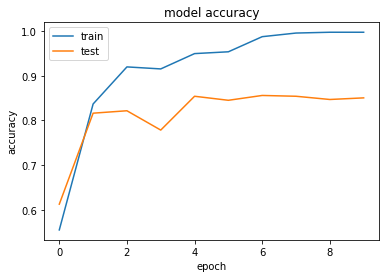

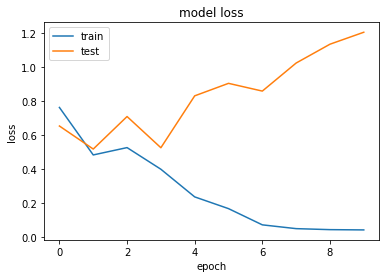

In [ ]:
plot_history(history_bidi)

In [ ]:
y_pred=predict(model_bidi)

In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[ 838  521]
 [  94 1510]] 

L accuracy sur le jeu de test est :
 0.7924400944988188


L'accuracy est un peu plus meilleur que pour les LSTM bi

L'utilisation de la bidirectionnelle exécutera nos entrées de deux manières, l'une du passé au futur et l'autre du futur au passé. Ce qui fait la difference avec les LSTM normal qui sont capables à tout moment de préserver les informations du passé et du futur.



# Plusieurs couches LSTM.

In [279]:
embed_size = 64                                                 # dimension de l'embedding
RNN_size   = 64

model = Sequential()
model.add(Embedding(num_words, embed_size, mask_zero=True))   
model.add(Bidirectional(LSTM(RNN_size,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))


model.summary()
# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     (None, None, 64)          320000    
_________________________________________________________________
bidirectional_49 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_102 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 65        
Total params: 431,489
Trainable params: 431,489
Non-trainable params: 0
_______________________________________________

In [280]:
history = model.fit(x_train,y_train, epochs=10,
                    validation_data=(x_test,y_test),
                    validation_steps=30)

Epoch 1/10
87/87 [==============================] - 49s 378ms/step - loss: 0.6906 - accuracy: 0.4457 - val_loss: 0.6888 - val_accuracy: 0.4587
Epoch 2/10
87/87 [==============================] - 28s 321ms/step - loss: 0.6818 - accuracy: 0.4464 - val_loss: 0.6774 - val_accuracy: 0.4587
Epoch 3/10
87/87 [==============================] - 28s 318ms/step - loss: 0.5963 - accuracy: 0.6740 - val_loss: 0.5232 - val_accuracy: 0.7503
Epoch 4/10
87/87 [==============================] - 28s 319ms/step - loss: 0.3678 - accuracy: 0.8695 - val_loss: 0.4147 - val_accuracy: 0.8367
Epoch 5/10
87/87 [==============================] - 28s 321ms/step - loss: 0.2180 - accuracy: 0.9264 - val_loss: 0.3762 - val_accuracy: 0.8296
Epoch 6/10
87/87 [==============================] - 28s 320ms/step - loss: 0.1354 - accuracy: 0.9571 - val_loss: 0.4249 - val_accuracy: 0.8512
Epoch 7/10
87/87 [==============================] - 28s 318ms/step - loss: 0.0832 - accuracy: 0.9798 - val_loss: 0.4795 - val_accuracy: 0.8522

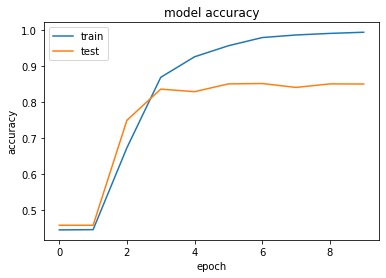

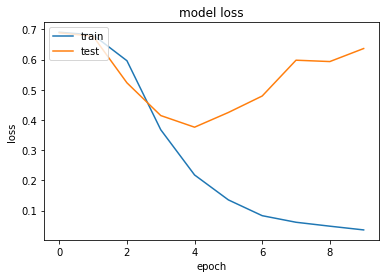

In [281]:
plot_history(history)

In [282]:
y_pred=predict(model)

In [283]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[1049  310]
 [ 144 1460]] 

L accuracy sur le jeu de test est :
 0.8467769152885589
